Ejemplo: Modelo basado en encoders
===============================

Introducción
------------

Una de las formás más sencillas de utilizar esta idea es simplemente utilizando el vector resultante de la red RNN. De esta forma al modelo observa el estado final al que ha arrivado la red y toma una decisión dependiendo del caso a resolver. Tipicamente este vector resultante es conectado a una capa densa (fully connected layer) para general la predicción. Los grandientes de los errores son propagados en la red para toda la secuencia y suele ser cualquier función típica como ser `cross entropy`, `hinge`, etc.

Veremos como podemos aplicar esta idea para resolver nuestro problema de clasificación de tweets

### Para ejecutar este notebook

Para ejecutar este notebook, instale las siguientes librerias:

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Datasets/mascorpus/tweets_marketing.csv \
    --quiet --no-clobber --directory-prefix ./Datasets/mascorpus/
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Utils/TextNormalizer.py \
    --quiet --no-clobber --directory-prefix ./Utils/
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Utils/PadSequenceTransformer.py \
    --quiet --no-clobber --directory-prefix ./Utils/
    
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/nlp/neural/sequences-encoder.txt \
    --quiet --no-clobber
!pip install -r sequences-encoder --quiet

Descargamos nuestros vectores de word2vec en español

In [ ]:
!mkdir -p ./Models/Word2Vec
!wget https://santiagxf.blob.core.windows.net/public/Word2Vec/model-es.bin \
    --quiet --no-clobber --directory-prefix ./Models/Word2Vec

In [1]:
import warnings
warnings.filterwarnings('ignore')

Instalamos las librerias necesarias

In [ ]:
!python -m spacy download es_core_news_sm

Cargamos el set de datos

In [2]:
import pandas as pd

tweets = pd.read_csv('Datasets/mascorpus/tweets_marketing.csv')

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets['TEXTO'], tweets['SECTOR'], 
                                                    test_size=0.33, 
                                                    stratify=tweets['SECTOR'])

## Preprocesamiento de texto

Al igual que con Topic Modeling, nuestro primer paso es preprocesar el texto. Para focalizarnos en Word2Vec en este modulo, les preparé un modulo TweetTextNormalizer que hará todo el preprocesamiento por nosotros. Pueden explorar los parametros que recibe el constructor de esta clase para ver que opciones podemos configurar como Stemmer, Lemmatization, etc.

En lo particular, estamos creando un TweetTextNormalizer que:
 - Aplicará un tokenizer especifico para Twitter
 - Eliminará stop words
 - Aplicará lemmatization
 - Eliminará URLs
 - Eliminará acentos
 - Eliminará las mayusculas
 
Adicionalmente, el parametro text_to_sequence=True indica que la salida de este proceso no serán oraciones sino que tokens.

In [4]:
from Utils.TextNormalizer import TweetTextNormalizer

In [5]:
normalizer = TweetTextNormalizer(preserve_case=False, text_to_sequence=True, token_min_len=2)

Podemos probar como funciona:

In [6]:
normalized_tweets = list(normalizer.transform(tweets["TEXTO"]))

## Vectorización de las palabras

En las actividades anteriores utilizamos siempre un TF-IDF vectorizer para generar los vectores. En esta oportunidad utilizaremos vectores densos. Aprenderemos estos vectores densos como parte de la red que estamos entrenando.

Por este motivo, realizaremos una vectorización utilizando `index-based encoding`.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(normalized_tweets)

Verifiquemos el vocabulario resultante:

In [9]:
vocab_size = tokenizer.num_words + 1
print('El tamaño del vocabulario es: %d' % vocab_size)

El tamaño del vocabulario es: 10001


Veamos algunos de los vectores resultantes:

In [10]:
list(tokenizer.word_index.items())[:20]

[('...', 1),
 ('adir', 2),
 ('heineken', 3),
 ('nike', 4),
 ('ikea', 5),
 ('mercadona', 6),
 ('bbva', 7),
 ('movistar', 8),
 ('cruzcampo', 9),
 ('carrefour', 10),
 ('ir', 11),
 ('bimbo', 12),
 ('hacer', 13),
 ('comprar', 14),
 ('poder', 15),
 ('toyota', 16),
 ('milka', 17),
 ('bankia', 18),
 ('bueno', 19),
 ('nuevo', 20)]

Aplicamos la transformación para pasar de palabras a indices:

In [11]:
input_tweets = tokenizer.texts_to_sequences(normalized_tweets)

## Construirmos un modelo basado en secuencias

### Ajustando la longitud de las secuencias

Los modelos basados en secuencias pueden adaptarse a cualquier longitud de secuencia, sin embargo, los parametros de nuestras redes neuronales deberan ser fijos. Para esto definiermos una longitud máxima de la secuencia que vamos analizar. Para esto podemos utilizar un valor especifico o utilizar el valor máximo de tokens que hay en nuestro corpus.

Para saber que valor es el correcto, podemos graficar la distribución de cantidad de palabras en los tweets:

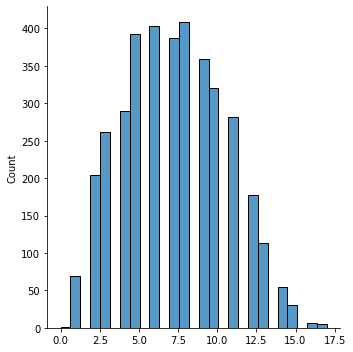

In [12]:
tweets_lens = [len(n) for n in input_tweets]
tweets_lens

import seaborn as sns
sns.displot(tweets_lens)

Utilicemos entonces:

In [13]:
max_seq_len = 50

La siguiente clase PadSequenceTransformer es un modulo que les preparé para simplificar este procesamiento. El mismo se encarga de ajustar cualquier secuencia para que tenga exactamente max_seq_len. Cuando la lingitud es mejor, se completan con ceros.

In [14]:
from Utils.PadSequenceTransformer import PadSequenceTransformer

In [15]:
padder = PadSequenceTransformer(max_len=max_seq_len)

In [16]:
input_tweets_padded = padder.transform(input_tweets)

Convertimos nuestra entrada a arreglos de tipo `numpy`

In [18]:
import numpy as np

input_tweets_np =  np.array(input_tweets_padded).astype('int32')

### Creando conjuntos de entrenamiento y validación

Crearemos 2 conjuntos de datos para entrenar y validar

In [19]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(len(input_tweets_np)), 
                                       test_size=0.33, 
                                       stratify=tweets['SECTOR'])

Necesitamos la variable de salida codificada también en forma de indices:

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(tweets["SECTOR"])
number_classes = len(label_encoder.classes_)

Creamos los conjuntos de datos:

In [21]:
X_train = np.array(input_tweets_np[idx_train]).astype('int32')
y_train = np.array(label_encoder.transform(tweets["SECTOR"][idx_train]))

X_test = np.array(input_tweets_np[idx_test]).astype('int32')
y_test = np.array(label_encoder.transform(tweets["SECTOR"][idx_test]))

In [22]:
print("Training:", X_train.shape)
print("Testing:", X_test.shape)

Training: (2521, 50)
Testing: (1242, 50)


### Construyendo el modelo

Para construir nuestro modelo, utilizaremos TensorFlow. En particular utilizaremos la API de Keras que nos permite componer modelos de redes neuronales como una secuencia de pasos o capas que se conectan en una dirección. 

Utilizemos los siguientes tipos de capas:
 *  **Embedding:** Esta capa transforma vectores que representan indices dentro de una matriz en representaciones vectoriales densas. Básicamente en este caso nos resolverá la busqueda de las representaciones vectoriales para nuestras palabras. **Intentaremos aprender embdeddings de tamaño 100**
 * **SpatialDropout1D:** Este tipo de capas ayudan a promover la independencia entre filtros (feature maps). Funciona en forma analoga a Dropout pero en lugar de desconectar elementos individuales, desconecta el filtro completo.
 * **LSTM:** Long Short-Term Memory layer - Hochreiter 1997
 * **Dense:** Una típica capa de una red neuronal completamente conectada (fully connected)
 
Algunos detalles para notar:
 * *loss='sparse_categorical_crossentropy'*, este problema de clasificación (crossentropy) de más de una clase (categorical). Sin embargo, nuestro output produce probabilidades de cada una de las clases posibles (7) en forma one-hot encoding. 
 * *metrics=['accuracy']*: Si bien nuestra metrica es accuracy, Keras hará un promedio ponderado del accuracy de cada clase. Este es el comportamiento por defecto.

In [23]:
emdedding_size = 100

In [24]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, LSTM, SpatialDropout1D

In [25]:
model = Sequential([
    Embedding(input_dim=vocab_size, 
              input_length=max_seq_len,
              output_dim=emdedding_size,
              mask_zero=True),
    SpatialDropout1D(0.2),
    LSTM(emdedding_size),
    Dense(number_classes, activation="softmax", name="output")
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])

2021-09-22 17:01:21.211473: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-22 17:01:21.211602: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-22 17:01:21.212528: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (laptop): /proc/driver/nvidia/version does not exist
2021-09-22 17:01:21.213851: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-09-22 17:01:21.224121: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1497600000 Hz
2021-09-22 17:01:21.226572: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb614000b60 initialized for platform Host (this does not guarantee 

Podemos inspeccionar el modelo:

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1000100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
output (Dense)               (None, 7)                 707       
Total params: 1,081,207
Trainable params: 1,081,207
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

Entrenamos nuestro modelo

In [27]:
history = model.fit(X_train,
                    y_train,
                    batch_size=124,
                    epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
21/21 [==============================] - 3s 136ms/step - loss: 1.9097 - accuracy: 0.3610 - val_loss: 1.8371 - val_accuracy: 0.4130
Epoch 2/20
21/21 [==============================] - 2s 116ms/step - loss: 1.6095 - accuracy: 0.5422 - val_loss: 1.3369 - val_accuracy: 0.6498
Epoch 3/20
21/21 [==============================] - 3s 120ms/step - loss: 0.8766 - accuracy: 0.8183 - val_loss: 0.8414 - val_accuracy: 0.8229
Epoch 4/20
21/21 [==============================] - 2s 103ms/step - loss: 0.3740 - accuracy: 0.9576 - val_loss: 0.6677 - val_accuracy: 0.8567
Epoch 5/20
21/21 [==============================] - 2s 118ms/step - loss: 0.1883 - accuracy: 0.9829 - val_loss: 0.6239 - val_accuracy: 0.8663
Epoch 6/20
21/21 [==============================] - 3s 121ms/step - loss: 0.1007 - accuracy: 0.9929 - val_loss: 0.6850 - val_accuracy: 0.8680
Epoch 7/20
21/21 [==============================] - 3s 119ms/step - loss: 0.0683 - accuracy: 0.9933 - val_loss: 0.7685 - val_accuracy: 0.8583
Epoch 

## Evalución de los resultados

Probamos su performance utilizando el test set

In [32]:
predictions = model.predict(X_test).argmax(axis=-1)

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

ALIMENTACION       0.93      0.89      0.91       110
  AUTOMOCION       0.84      0.89      0.86       148
       BANCA       0.92      0.84      0.88       198
     BEBIDAS       0.84      0.85      0.84       223
    DEPORTES       0.97      0.90      0.93       216
      RETAIL       0.85      0.90      0.88       268
       TELCO       0.72      0.82      0.77        79

    accuracy                           0.87      1242
   macro avg       0.87      0.87      0.87      1242
weighted avg       0.88      0.87      0.87      1242

